In [1]:
import pickle
import torch
import os
import matplotlib.pyplot as plt
from src.utils.paths import get_path
from src.utils.utils import CPU_Unpickler
from pathlib import Path
from src.dataset.dataset import EventDataset

filename = get_path("/work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_2025_01_03_15_07_14/eval_0.pkl", "results")
# for rinv=0.7, see /work/gkrzmanc/jetclustering/results/train/Test_betaPt_BC_rinv07_2025_01_03_15_38_58

result = CPU_Unpickler(open(filename, "rb")).load()
dataset = EventDataset.from_directory(result["filename"], mmap=True)


/work/gkrzmanc/gatr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
result.keys()

dict_keys(['event_idx', 'GT_cluster', 'pred', 'eta', 'phi', 'pt', 'AK8_cluster', 'radius_cluster_GenJets', 'radius_cluster_FatJets', 'filename'])

In [6]:
from src.jetfinder.basicjetfinder import basicjetfinder
from src.jetfinder.basicjetfinder_types import PseudoJet

In [7]:
event = dataset[1]

In [8]:
def get_pseudojets(event):
    pseudojets = []
    for i in range(len(event.pfcands)):
        pseudojets.append(PseudoJet(event.pfcands.pxyz[i, 0].item(), event.pfcands.pxyz[i, 1].item(), event.pfcands.pxyz[i, 2].item(), event.pfcands.E[i].item()))
    return pseudojets
import fastjet
def get_pseudojets_fastjet(event):
    pseudojets = []
    for i in range(len(event.pfcands)):
        pseudojets.append(fastjet.PseudoJet(event.pfcands.pxyz[i, 0].item(), event.pfcands.pxyz[i, 1].item(), event.pfcands.pxyz[i, 2].item(), event.pfcands.E[i].item()))
    return pseudojets

In [9]:
pj = get_pseudojets(event)
init_jets, history = basicjetfinder(pj, return_raw=True)

In [10]:
pj[0].phi, pj[0].rap

(5.176739997422374, -1.1044922730459195)

In [11]:
event.pfcands.phi[0].item(), event.pfcands.eta[0].item()

(-1.1064453125, -1.1044921875)

In [12]:
history.parent1[-1], history.parent2[-1]
history.jetp_index[305]

305

In [13]:
jets = basicjetfinder(pj, return_raw=0, ptmin=100)

12


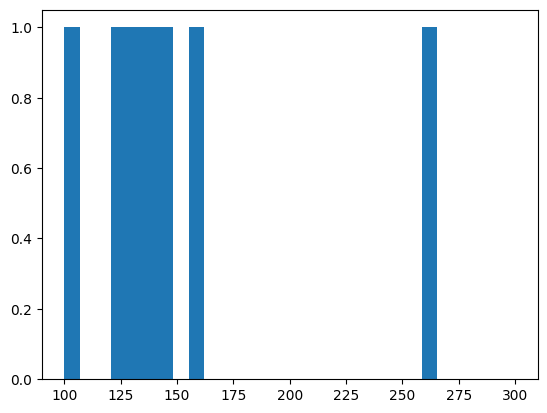

In [15]:
fig, ax = plt.subplots()
print(len(jets))
import numpy as np
pts = [jet.pt for jet in jets]
ax.hist(pts, bins=np.linspace(100, 300, 30))
fig.show()

In [16]:
pts

[106.4914540483752,
 126.82878103484677,
 128.75701244217592,
 139.36815083799416,
 141.45818096650805,
 157.3921266403816,
 263.460560295077,
 510.77385760617676,
 1265.8454239380796,
 3240.9516711140454,
 9355.60575745164,
 12409.915133671686]

In [14]:
history.parent1[-1], history.parent2[-1]


(305, -1)

In [15]:
history.parent1

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -

In [16]:
history.parent2

array([ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -

In [34]:
import fastjet
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.8)
array = get_pseudojets_fastjet(event)

cluster = fastjet.ClusterSequence(array, jetdef)
inc_jets = cluster.inclusive_jets()

for elem in inc_jets:
    pt = elem.pt()
    if pt < 100:
        continue
    print("pt:", elem.pt(), "eta:", elem.rap())

pt: 132.20828148108546 eta: -0.0754104485813396
pt: 200.7486894820125 eta: -1.148074263928614
pt: 401.81239814256105 eta: -1.1010204529261447


In [37]:
event.fatjets.pt.tolist(), event.fatjets.eta.tolist()

([401.8123779296875, 200.74868774414062, 126.27354431152344],
 [-1.1161537170410156, -1.205527901649475, -0.07039077579975128])